<a href="https://colab.research.google.com/github/sanjanb/Pranayama-reduces-BP-or-Not/blob/main/Preprocessing_of_Pranayama_%5Bafter_resampled_dataset%5D_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing Two datasets**

In [ ]:
import pandas as pd

# Load Lancet dataset
df_lancet = pd.read_csv('/content/NCD_RisC_Lancet_2017_BP_age_standardised_world.csv')

# Calculate mean BP for Men and Women
lancet_men = df_lancet[df_lancet['Sex'] == 'Men'].mean(numeric_only=True)
lancet_women = df_lancet[df_lancet['Sex'] == 'Women'].mean(numeric_only=True)

# Create aggregated Lancet dataframe
df_lancet_agg = pd.DataFrame({
    'Sex': ['Men', 'Women'],
    'Systolic BP': [lancet_men['Mean systolic blood pressure (mmHg)'], lancet_women['Mean systolic blood pressure (mmHg)']],
    'Diastolic BP': [lancet_men['Mean diastolic blood pressure (mmHg)'], lancet_women['Mean diastolic blood pressure (mmHg)']],
    'Pranayama': [0, 0]
})

## **Combining Them**

In [ ]:
# Load Pranayama dataset
df_pranayama = pd.read_excel('/content/Pranayama_Datset.xlsx', sheet_name='Sheet1')

def split_bp(bp_str):
    """Split BP string (e.g., '120/80') into systolic and diastolic values."""
    try:
        return list(map(int, bp_str.split('/')))
    except:
        return None, None

# Extract post-pranayama BP values
df_pranayama['After_Systolic'] = None
df_pranayama['After_Diastolic'] = None

for day in ['D1', 'D2', 'D3']:
    col = f'{day} After Pranayama BP Measurment'
    systolic = []
    diastolic = []
    for idx, row in df_pranayama.iterrows():
        if pd.notna(row[col]):
            sys, dia = split_bp(row[col])
            systolic.append(sys)
            diastolic.append(dia)
        else:
            systolic.append(None)
            diastolic.append(None)
    df_pranayama[f'{day}_sys'] = systolic
    df_pranayama[f'{day}_dia'] = diastolic

# Calculate average post-pranayama BP
df_pranayama['Systolic BP'] = df_pranayama[['D1_sys', 'D2_sys', 'D3_sys']].mean(axis=1, skipna=True)
df_pranayama['Diastolic BP'] = df_pranayama[['D1_dia', 'D2_dia', 'D3_dia']].mean(axis=1, skipna=True)

# Clean and format
df_pranayama = df_pranayama[['Gender', 'Systolic BP', 'Diastolic BP']].dropna()
df_pranayama['Sex'] = df_pranayama['Gender'].replace({'M': 'Men', 'F': 'Women'})
df_pranayama['Pranayama'] = 1
df_pranayama = df_pranayama[['Sex', 'Systolic BP', 'Diastolic BP', 'Pranayama']]

In [ ]:
df_combined = pd.concat([df_lancet_agg, df_pranayama], ignore_index=True)
df_combined

,Sex,Systolic BP,Diastolic BP,Pranayama
0,Men,126.40257,78.688567,0
1,Women,122.89571,76.855848,0
2,Women,118.00000,77.000000,1
3,Men,161.50000,77.500000,1
4,Men,126.00000,73.000000,1
...,...,...,...,...
61,Men,139.00000,76.000000,1
62,Men,110.50000,67.000000,1
63,Women,112.00000,69.000000,1
64,Men,135.00000,80.000000,1


## **Statistical Analysis**

In [ ]:
from scipy.stats import ttest_ind

# Split groups
group0 = df_combined[df_combined['Pranayama'] == 0]
group1 = df_combined[df_combined['Pranayama'] == 1]

# T-test for Systolic BP
t_stat_systolic, p_systolic = ttest_ind(group0['Systolic BP'], group1['Systolic BP'])
print(f"Systolic BP: t-statistic={t_stat_systolic}, p-value={p_systolic}")

# T-test for Diastolic BP
t_stat_diastolic, p_diastolic = ttest_ind(group0['Diastolic BP'], group1['Diastolic BP'])
print(f"Diastolic BP: t-statistic={t_stat_diastolic}, p-value={p_diastolic}")

Systolic BP: t-statistic=-0.3295700874708399, p-value=0.7428010539294241
Diastolic BP: t-statistic=0.228197172160611, p-value=0.8202204898147686


## **BoxPlots Analysis**

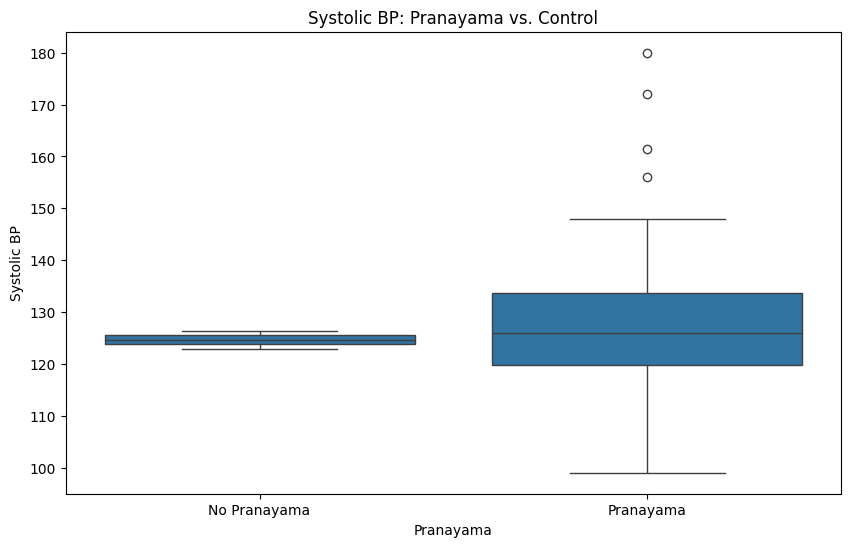

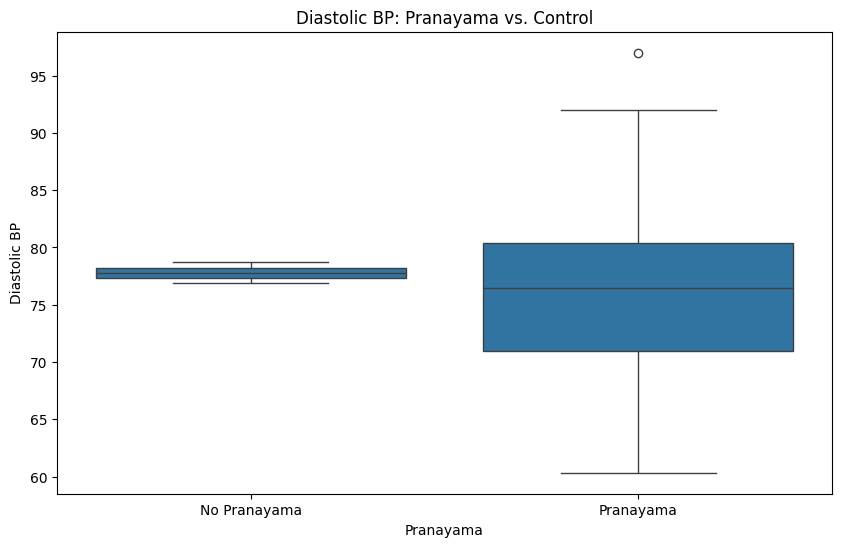

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for Systolic BP
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pranayama', y='Systolic BP', data=df_combined)
plt.title('Systolic BP: Pranayama vs. Control')
plt.xticks([0, 1], ['No Pranayama', 'Pranayama'])
plt.show()

# Boxplot for Diastolic BP
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pranayama', y='Diastolic BP', data=df_combined)
plt.title('Diastolic BP: Pranayama vs. Control')
plt.xticks([0, 1], ['No Pranayama', 'Pranayama'])
plt.show()

## **Apllying SMOTE to increase the number of data**

In [ ]:
pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate features and target variable
X = df_combined[['Systolic BP', 'Diastolic BP']] # Corrected column names
y = df_combined['Pranayama']

# Apply SMOTE to generate synthetic samples
smote = SMOTE(random_state=42, sampling_strategy=0.5, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

# Combine the resampled features and target variable into a new DataFrame
resampled_df = pd.DataFrame(X_res, columns=['Systolic BP', 'Diastolic BP']) # Corrected column names
resampled_df['Pranayama'] = y_res

# Display the first few rows of the resampled dataset
print(resampled_df.head())
print(resampled_df.shape)

   Systolic BP  Diastolic BP  Pranayama
0    126.40257     78.688567          0
1    122.89571     76.855848          0
2    118.00000     77.000000          1
3    161.50000     77.500000          1
4    126.00000     73.000000          1
(96, 3)


In [ ]:

from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate features and target variable
X = df_combined[['Systolic BP', 'Diastolic BP']]
y = df_combined['Pranayama']


smote = SMOTE(random_state=42, sampling_strategy=1.0, k_neighbors=1) # Changed sampling_strategy
X_res, y_res = smote.fit_resample(X, y)

# Combine the resampled features and target variable into a new DataFrame
resampled_df = pd.DataFrame(X_res, columns=['Systolic BP', 'Diastolic BP'])
resampled_df['Pranayama'] = y_res

# Display the first few rows of the resampled dataset
print(resampled_df.head())
print(resampled_df.shape) # This should now show (128, 3) if sampling_strategy=1.0

   Systolic BP  Diastolic BP  Pranayama
0    126.40257     78.688567          0
1    122.89571     76.855848          0
2    118.00000     77.000000          1
3    161.50000     77.500000          1
4    126.00000     73.000000          1
(128, 3)


In [ ]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Separate features and target variable
X = df_combined[['Systolic BP', 'Diastolic BP']]
y = df_combined['Pranayama']


target_samples = {0: 200, 1: 64}

smote = SMOTE(random_state=42, sampling_strategy=target_samples, k_neighbors=1)
X_res, y_res = smote.fit_resample(X, y)

# Combine the resampled features and target variable into a new DataFrame
resampled_df = pd.DataFrame(X_res, columns=['Systolic BP', 'Diastolic BP'])
resampled_df['Pranayama'] = y_res

# Display the first few rows of the resampled dataset
print(resampled_df.head())
print(resampled_df.shape)

   Systolic BP  Diastolic BP  Pranayama
0    126.40257     78.688567          0
1    122.89571     76.855848          0
2    118.00000     77.000000          1
3    161.50000     77.500000          1
4    126.00000     73.000000          1
(264, 3)


In [ ]:
df_pranayama['Sex'] = df_pranayama['Sex'].replace({'M': 'Men', 'F': 'Women'})

# Group by 'Sex' and 'Pranayama' and count the number of entries
sex_pranayama_counts = df_combined.groupby(['Sex', 'Pranayama']).size().reset_index(name='Count')

# Display the counts
print(sex_pranayama_counts)

     Sex  Pranayama  Count
0     M           1      1
1    Men          0      1
2    Men          1     32
3  Women          0      1
4  Women          1     31


In [ ]:
# Save the resampled DataFrame to a CSV file
resampled_df.to_csv('resampled_data.csv', index=False)

print("Resampled data saved to 'resampled_data.csv'")

Resampled data saved to 'resampled_data.csv'


In [ ]:
# Check the value counts of the target variable in the resampled dataset
print(resampled_df['Pranayama'].value_counts())

Pranayama
0    200
1     64
Name: count, dtype: int64


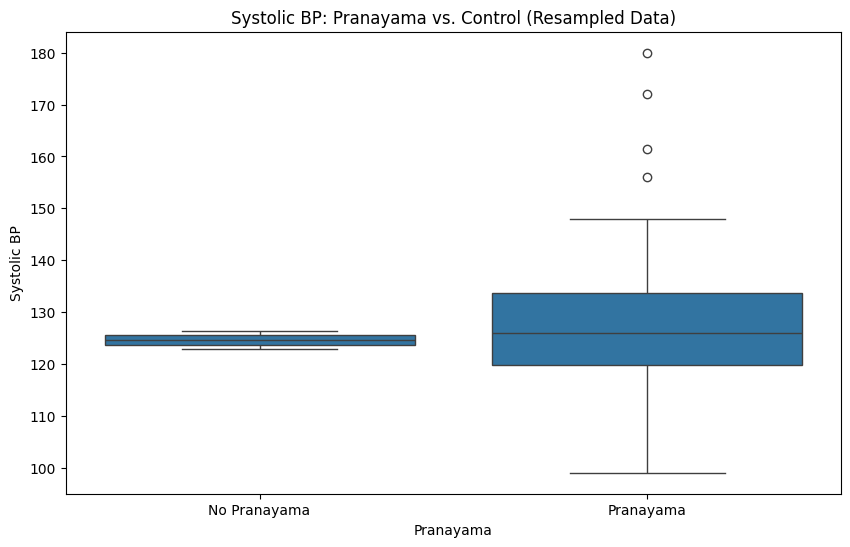

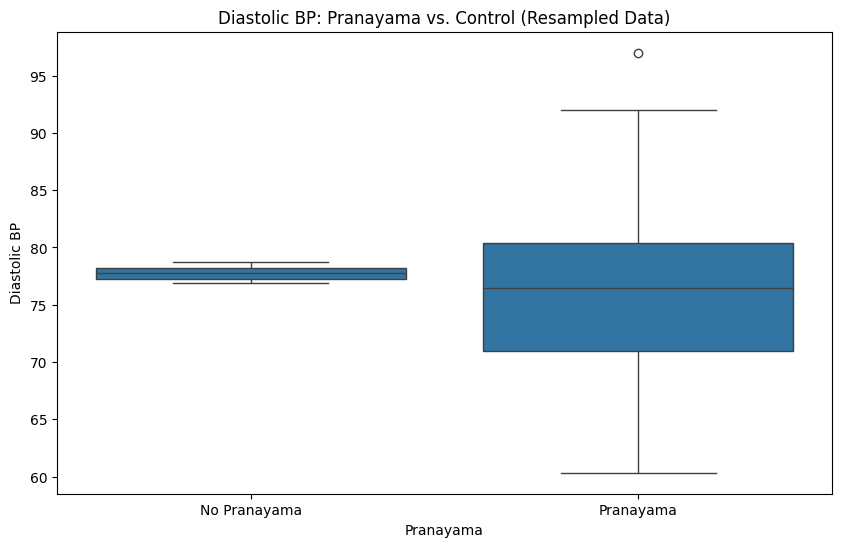

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for Systolic BP with resampled data
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pranayama', y='Systolic BP', data=resampled_df)
plt.title('Systolic BP: Pranayama vs. Control (Resampled Data)')
plt.xticks([0, 1], ['No Pranayama', 'Pranayama'])
plt.show()

# Boxplot for Diastolic BP with resampled data
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pranayama', y='Diastolic BP', data=resampled_df)
plt.title('Diastolic BP: Pranayama vs. Control (Resampled Data)')
plt.xticks([0, 1], ['No Pranayama', 'Pranayama'])
plt.show()

## **Using newly Sampled data for the process**

# Task
Import this data, do some EDA on it

Here is all the data you need:
"resampled_data.csv"

## Data loading

### Subtask:
Load the data from "resampled_data.csv" into a pandas DataFrame.


**Reasoning**:
Load the data from "resampled_data.csv" into a pandas DataFrame and display the first 5 rows.



In [ ]:
import pandas as pd

try:
    df = pd.read_csv('resampled_data.csv')
    display(df.head())
except FileNotFoundError:
    print("Error: 'resampled_data.csv' not found.")
    df = None
except pd.errors.ParserError:
    print("Error: Could not parse 'resampled_data.csv'. Check file format.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    df = None

,Systolic BP,Diastolic BP,Sex_Men,Sex_Women,Pranayama
0,126.402570,78.688567,True,False,0
1,122.895711,76.855848,False,True,0
2,118.000000,77.000000,False,True,1
3,161.500000,77.500000,True,False,1
4,126.000000,73.000000,True,False,1


## Data exploration

### Subtask:
Explore the loaded data to understand its structure and characteristics.


**Reasoning**:
Explore the data by checking its shape, data types, descriptive statistics, and value counts for categorical features.



In [ ]:
# Check the shape of the DataFrame
print("Shape of the DataFrame:", df.shape)

# Examine the data types of each column
print("\nData Types of each column:\n", df.dtypes)

# Generate descriptive statistics for numerical features
print("\nDescriptive Statistics for Numerical Features:\n", df.describe())

# Analyze categorical features
print("\nValue Counts for Categorical Features:")
for col in ['Sex_Men', 'Sex_Women']:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())

Shape of the DataFrame: (264, 5)

Data Types of each column:
 Systolic BP     float64
Diastolic BP    float64
Sex_Men            bool
Sex_Women          bool
Pranayama         int64
dtype: object

Descriptive Statistics for Numerical Features:
        Systolic BP  Diastolic BP   Pranayama
count   264.000000    264.000000  264.000000
mean    125.422383     77.453524    0.242424
std       7.168831      3.784959    0.429364
min      99.000000     60.333333    0.000000
25%     123.558709     77.151692    0.000000
50%     124.671023     77.688472    0.000000
75%     125.915705     78.334226    0.000000
max     180.000000     97.000000    1.000000

Value Counts for Categorical Features:

Column: Sex_Men
Sex_Men
False    148
True     116
Name: count, dtype: int64

Column: Sex_Women
Sex_Women
True     147
False    117
Name: count, dtype: int64


## Data visualization

### Subtask:
Visualize the distribution of data using histograms and bar charts.


**Reasoning**:
Visualize the distribution of numerical and categorical features using histograms and bar charts, respectively.  Analyze the generated visualizations for potential outliers, skewed distributions, or patterns.



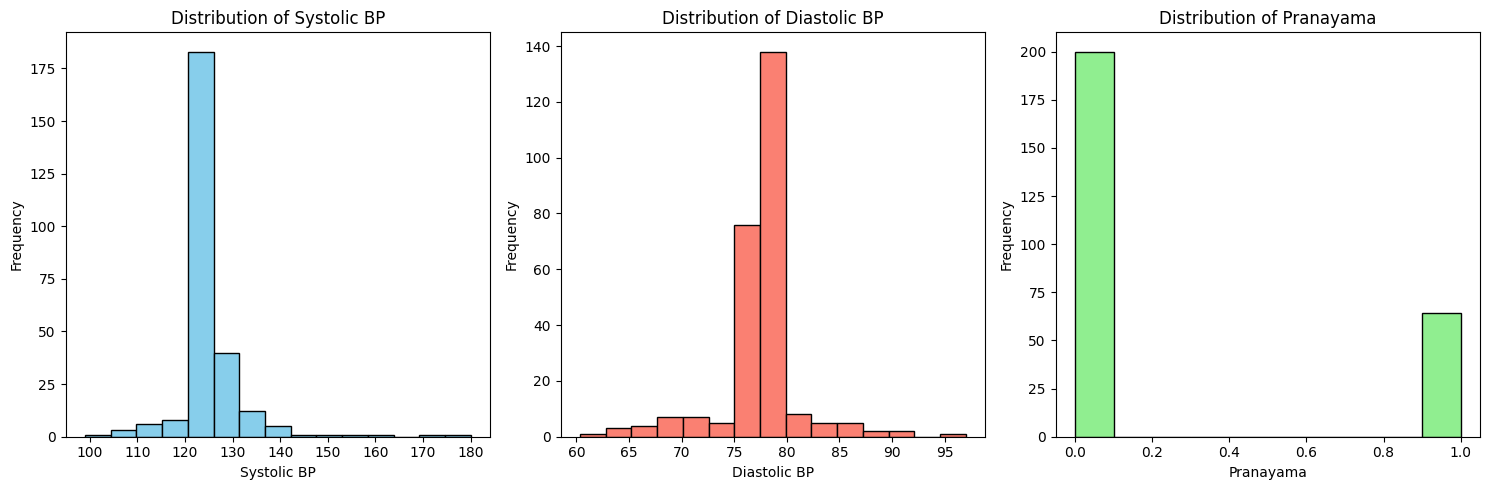

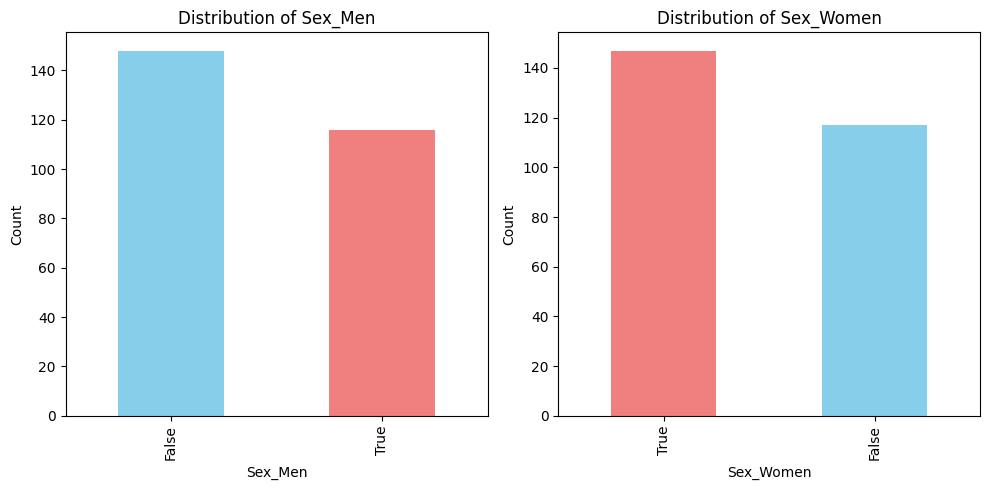

In [ ]:
import matplotlib.pyplot as plt

# Histograms for numerical features
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Systolic BP'], bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of Systolic BP')
plt.xlabel('Systolic BP')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(df['Diastolic BP'], bins=15, color='salmon', edgecolor='black')
plt.title('Distribution of Diastolic BP')
plt.xlabel('Diastolic BP')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(df['Pranayama'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution of Pranayama')
plt.xlabel('Pranayama')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Bar charts for categorical features
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
df['Sex_Men'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Sex_Men')
plt.xlabel('Sex_Men')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['Sex_Women'].value_counts().plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Distribution of Sex_Women')
plt.xlabel('Sex_Women')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Data analysis

### Subtask:
Calculate descriptive statistics and correlations for the numerical features in the dataframe.


**Reasoning**:
Calculate descriptive statistics and correlations for the numerical features, and visualize the correlation matrix using a heatmap.



Descriptive Statistics:
        Systolic BP  Diastolic BP   Pranayama
count   264.000000    264.000000  264.000000
mean    125.422383     77.453524    0.242424
std       7.168831      3.784959    0.429364
min      99.000000     60.333333    0.000000
25%     123.558709     77.151692    0.000000
50%     124.671023     77.688472    0.000000
75%     125.915705     78.334226    0.000000
max     180.000000     97.000000    1.000000

Correlation Matrix:
               Systolic BP  Diastolic BP  Pranayama
Systolic BP      1.000000      0.508278   0.202960
Diastolic BP     0.508278      1.000000  -0.137322
Pranayama        0.202960     -0.137322   1.000000


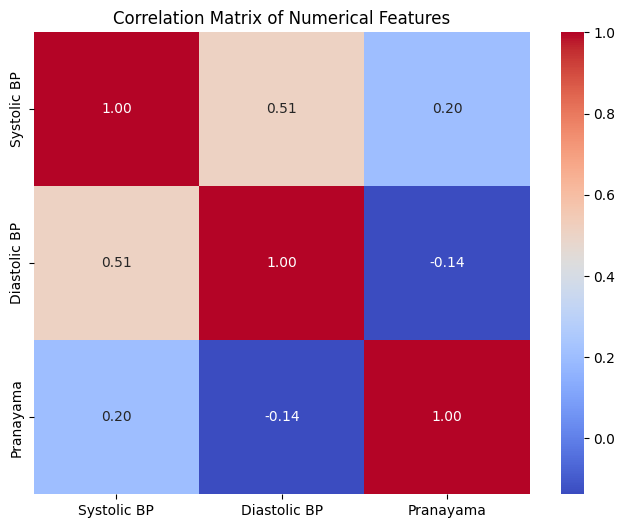

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate descriptive statistics
numerical_features = ['Systolic BP', 'Diastolic BP', 'Pranayama']
descriptive_stats = df[numerical_features].describe()
print("Descriptive Statistics:\n", descriptive_stats)

# Calculate the correlation matrix
correlation_matrix = df[numerical_features].corr()
print("\nCorrelation Matrix:\n", correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Summary:


### Data Analysis Key Findings
* The dataset contains 264 entries and 5 columns: 'Systolic BP', 'Diastolic BP', 'Sex\_Men', 'Sex\_Women', and 'Pranayama'.
* 'Systolic BP' and 'Diastolic BP' show a moderate positive correlation (0.51), indicating that higher systolic pressure tends to be associated with higher diastolic pressure.
* 'Systolic BP' has a weak positive correlation with 'Pranayama' (0.20).
* 'Diastolic BP' has a weak negative correlation with 'Pranayama' (-0.14).
* The mean systolic blood pressure is approximately 125.42, and the mean diastolic blood pressure is approximately 77.45.
* The gender representation in the dataset appears balanced.

